# Aquascan GNN Dataset Quality Control

This notebook performs sanity checks on the processed graph dataset to verify its correctness and quality.

In [38]:
import os
import sys
import json
import random
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Make sure the project root is in the Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
from aquascan.config.simulation_config import AREA_LENGTH, AREA_WIDTH, SHORE_DISTANCE

# Try to import torch_geometric (required for loading the graph files)
try:
    from torch_geometric.data import HeteroData
except ImportError:
    print("Warning: torch_geometric not installed. Install it with 'pip install torch_geometric'")

# Set paths
RAW_DIR = project_root / "data" / "raw"
PROCESSED_DIR = project_root / "data" / "processed"

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

## 1. Visual Sanity Checks

### 1.1 Random Raw Tick Visualization

First, let's visualize a random tick from a raw HDF5 file to check the ε and θ positions.

Selected random file: 1.h5
Selected random tick: 25
Found 570 ε-nodes and 11 θ-nodes


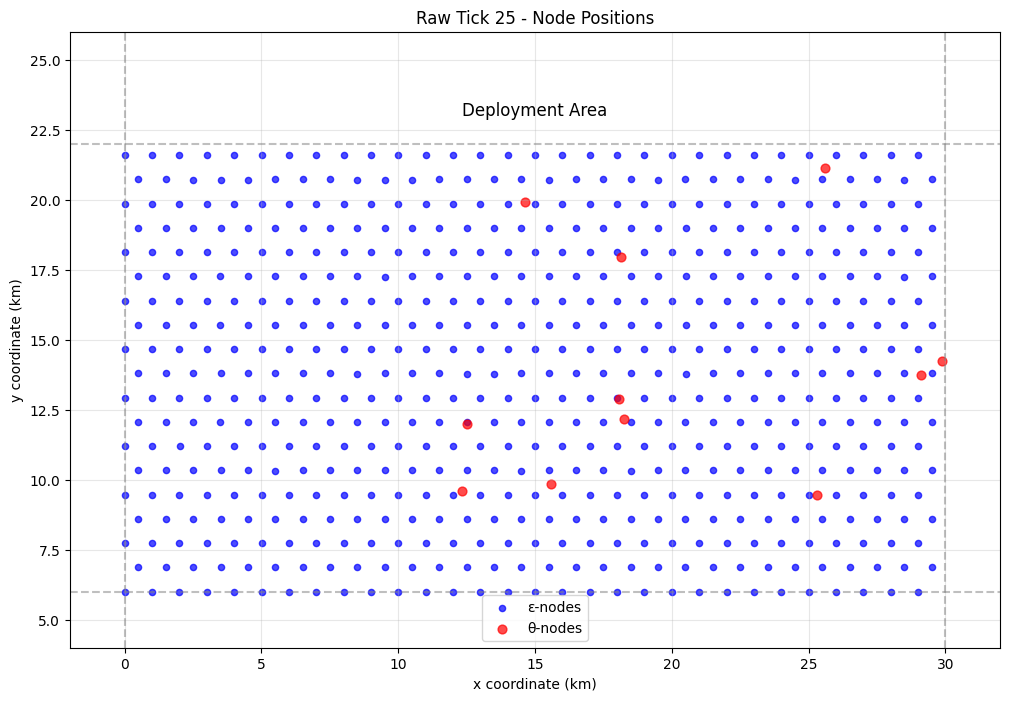

In [39]:
# Find all raw HDF5 files
h5_files = list(RAW_DIR.glob("*.h5"))
if not h5_files:
    print("No HDF5 files found in", RAW_DIR)
else:
    # Select a random file
    random_file = random.choice(h5_files)
    print(f"Selected random file: {random_file.name}")
    
    with h5py.File(random_file, 'r') as f:
        # Get available ticks
        ticks = np.unique(f['nodes']['t'])
        random_tick = random.choice(ticks)
        print(f"Selected random tick: {random_tick}")
        
        # Get nodes at this tick
        nodes = f['nodes'][f['nodes']['t'] == random_tick]
        
        # Split by type
        epsilon_nodes = nodes[nodes['type'] == 0]
        theta_nodes = nodes[nodes['type'] == 1]
        
        print(f"Found {len(epsilon_nodes)} ε-nodes and {len(theta_nodes)} θ-nodes")
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.scatter(epsilon_nodes['x'], epsilon_nodes['y'], s=20, c='blue', alpha=0.7, label='ε-nodes')
        plt.scatter(theta_nodes['x'], theta_nodes['y'], s=40, c='red', alpha=0.7, label='θ-nodes')
        
        # Draw deployment area boundary
        plt.axhline(y=SHORE_DISTANCE, color='grey', linestyle='--', alpha=0.5)
        plt.axhline(y=SHORE_DISTANCE + AREA_WIDTH, color='grey', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
        plt.axvline(x=AREA_LENGTH, color='grey', linestyle='--', alpha=0.5)
        
        # Add deployment area annotation
        plt.annotate('Deployment Area', xy=(AREA_LENGTH/2, SHORE_DISTANCE + AREA_WIDTH + 1), ha='center', fontsize=12)

        # Set plot limits with some margin
        plt.xlim(-2, AREA_LENGTH + 2)
        plt.ylim(SHORE_DISTANCE - 2, SHORE_DISTANCE + AREA_WIDTH + 4)
        
        plt.title(f"Raw Tick {random_tick} - Node Positions")
        plt.xlabel("x coordinate (km)")
        plt.ylabel("y coordinate (km)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

### 1.2 Random Processed Graph Visualization

Now, let's visualize a random graph from the processed data to check node positions and edges.

Selected random graph with context=60, horizon=30


/Users/adantas/dev/phd/aquascan-gnns/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


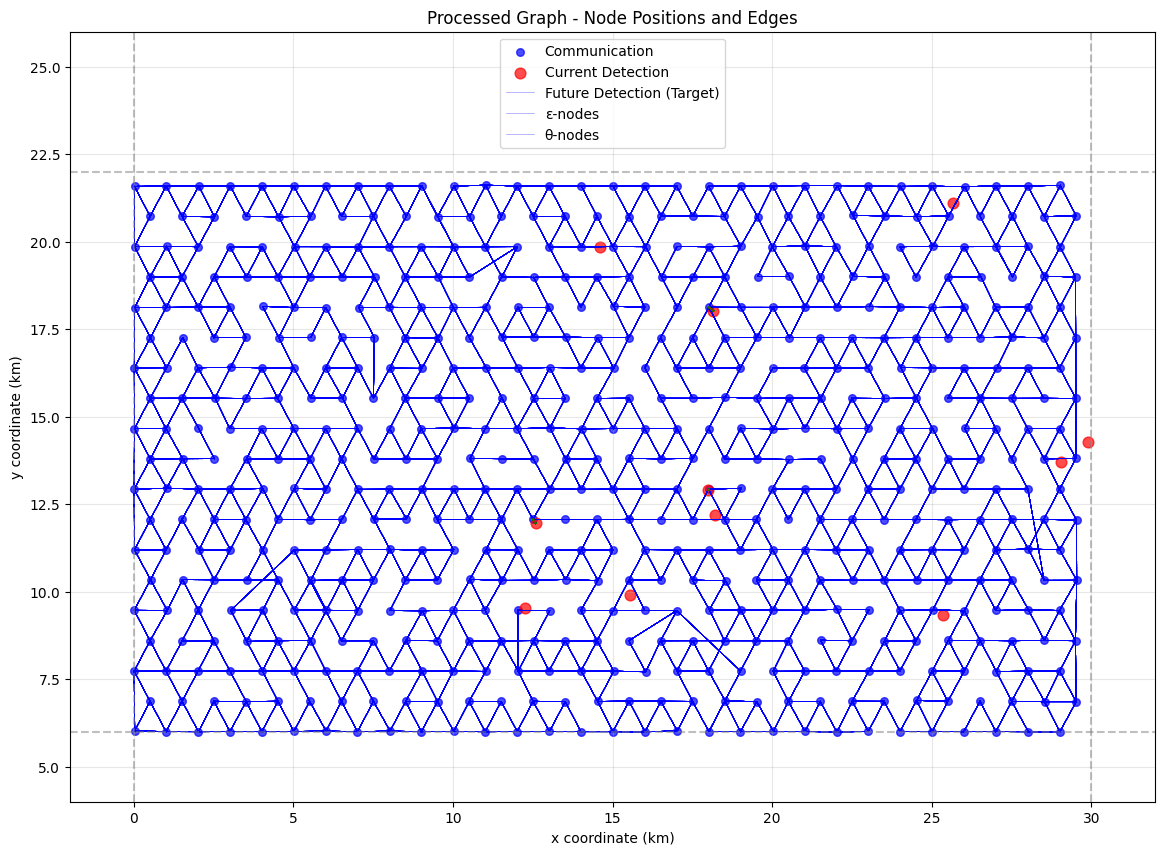

All epsilon nodes within area bounds: True
All theta nodes within area bounds: True


In [40]:
# Check if processed files exist
train_file = PROCESSED_DIR / "train.pt"
if not train_file.exists():
    print("No processed files found in", PROCESSED_DIR)
else:
    # Load a random graph from the training set
    train_graphs = torch.load(train_file, weights_only=False)
    random_graph = random.choice(train_graphs)
    
    print(f"Selected random graph with context={random_graph.context_len}, horizon={random_graph.horizon_len}")
    
    # Get node positions and edges
    epsilon_pos = random_graph['epsilon'].x[:, :2].numpy()  # x, y coordinates
    theta_pos = random_graph['theta'].x[:, :2].numpy() if 'theta' in random_graph.node_types else np.array([]).reshape(0, 2)
    
    # Get communication edges
    if ('epsilon', 'communicates', 'epsilon') in random_graph.edge_types:
        comm_edges = random_graph['epsilon', 'communicates', 'epsilon'].edge_index.numpy()
    else:
        comm_edges = np.zeros((2, 0), dtype=int)
    
    # Get detection edges
    if ('epsilon', 'detects', 'theta') in random_graph.edge_types:
        detect_edges = random_graph['epsilon', 'detects', 'theta'].edge_index.numpy()
    else:
        detect_edges = np.zeros((2, 0), dtype=int)
    
    # Get future detection labels
    if ('epsilon', 'will_detect', 'theta') in random_graph.edge_types:
        future_edge_idx = random_graph['epsilon', 'will_detect', 'theta'].edge_label_index.numpy()
        future_labels = random_graph['epsilon', 'will_detect', 'theta'].edge_label.numpy()
        # Filter to only positive future detections
        positive_idx = np.where(future_labels > 0.5)[0]
        future_edges = future_edge_idx[:, positive_idx]
    else:
        future_edges = np.zeros((2, 0), dtype=int)
    
    # Plot the graph
    plt.figure(figsize=(14, 10))
    
    # Plot epsilon nodes
    plt.scatter(epsilon_pos[:, 0], epsilon_pos[:, 1], s=30, c='blue', alpha=0.7, label='ε-nodes')
    
    # Plot theta nodes
    if len(theta_pos) > 0:
        plt.scatter(theta_pos[:, 0], theta_pos[:, 1], s=60, c='red', alpha=0.7, label='θ-nodes')
    
    # Plot communication edges
    for i in range(comm_edges.shape[1]):
        src, dst = comm_edges[0, i], comm_edges[1, i]
        plt.plot([epsilon_pos[src, 0], epsilon_pos[dst, 0]],
                 [epsilon_pos[src, 1], epsilon_pos[dst, 1]],
                 'b-', linewidth=0.5, alpha=0.4)
    
    # Plot detection edges
    for i in range(detect_edges.shape[1]):
        src, dst = detect_edges[0, i], detect_edges[1, i]
        plt.plot([epsilon_pos[src, 0], theta_pos[dst, 0]],
                 [epsilon_pos[src, 1], theta_pos[dst, 1]],
                 'g-', linewidth=1, alpha=0.6)
    
    # Plot future detection edges
    for i in range(future_edges.shape[1]):
        src, dst = future_edges[0, i], future_edges[1, i]
        plt.plot([epsilon_pos[src, 0], theta_pos[dst, 0]],
                 [epsilon_pos[src, 1], theta_pos[dst, 1]],
                 'r--', linewidth=1, alpha=0.7)
    
    # Draw deployment area boundary
    plt.axhline(y=SHORE_DISTANCE, color='grey', linestyle='--', alpha=0.5)
    plt.axhline(y=SHORE_DISTANCE + AREA_WIDTH, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=AREA_LENGTH, color='grey', linestyle='--', alpha=0.5)
    
    # Set plot limits with some margin
    plt.xlim(-2, AREA_LENGTH + 2)
    plt.ylim(SHORE_DISTANCE - 2, SHORE_DISTANCE + AREA_WIDTH + 4)
    
    plt.title(f"Processed Graph - Node Positions and Edges")
    plt.xlabel("x coordinate (km)")
    plt.ylabel("y coordinate (km)")
    plt.legend(['Communication', 'Current Detection', 'Future Detection (Target)', 'ε-nodes', 'θ-nodes'])
    plt.grid(alpha=0.3)
    plt.show()
    
    # Check if nodes are within the deployment area
    epsilon_in_x = np.logical_and(epsilon_pos[:, 0] >= -2, epsilon_pos[:, 0] <= AREA_LENGTH + 2)
    epsilon_in_y = np.logical_and(epsilon_pos[:, 1] >= SHORE_DISTANCE - 2, epsilon_pos[:, 1] <= SHORE_DISTANCE + AREA_WIDTH + 2)
    epsilon_in_area = np.logical_and(epsilon_in_x, epsilon_in_y)
    
    theta_in_x = True
    theta_in_y = True
    if len(theta_pos) > 0:
        theta_in_x = np.logical_and(theta_pos[:, 0] >= -2, theta_pos[:, 0] <= AREA_LENGTH + 2)
        theta_in_y = np.logical_and(theta_pos[:, 1] >= SHORE_DISTANCE - 2, theta_pos[:, 1] <= SHORE_DISTANCE + AREA_WIDTH + 2)
    theta_in_area = np.logical_and(theta_in_x, theta_in_y) if len(theta_pos) > 0 else True
    
    print(f"All epsilon nodes within area bounds: {epsilon_in_area.all()}")
    print(f"All theta nodes within area bounds: {theta_in_area.all() if isinstance(theta_in_area, bool) else theta_in_area.all()}")

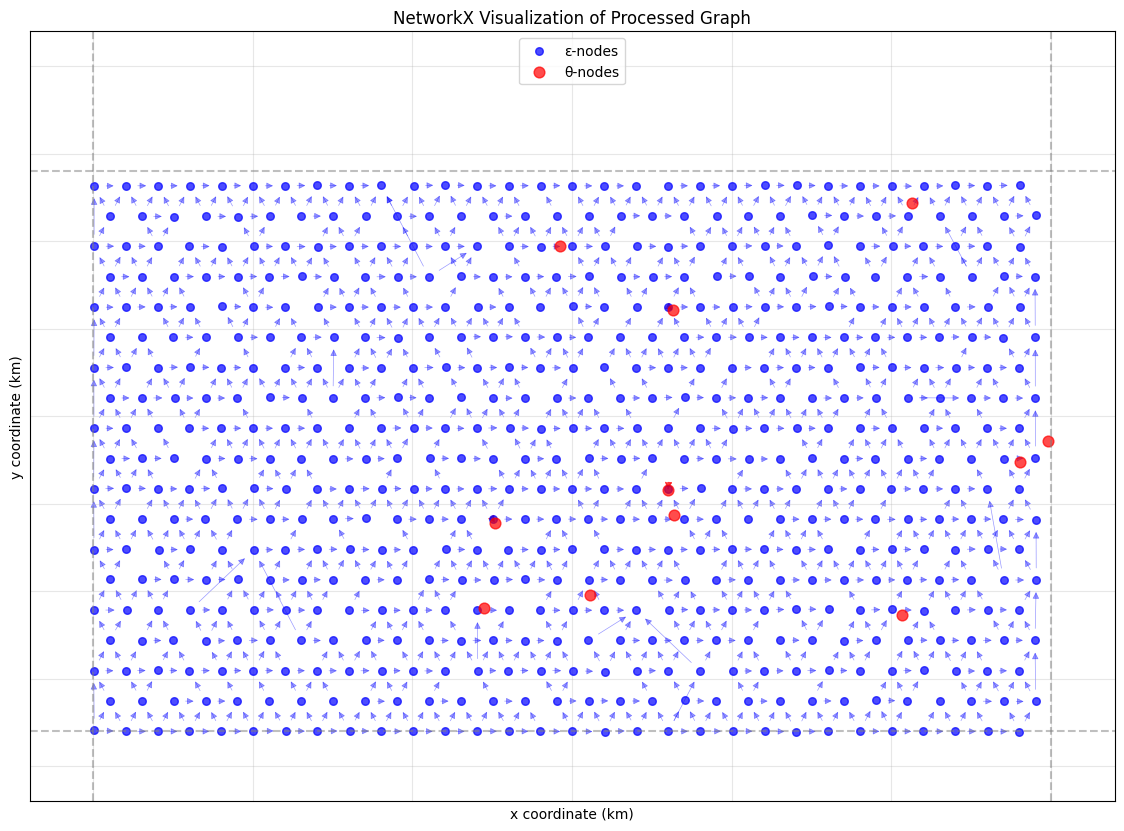

In [41]:
# NetworkX visualization of the same graph data
import networkx as nx

# Create a NetworkX graph
G = nx.DiGraph()

# Add epsilon nodes
for i, pos in enumerate(epsilon_pos):
    G.add_node(f"ε{i}", pos=(pos[0], pos[1]), node_type="epsilon", node_size=30, node_color="blue")

# Add theta nodes
for i, pos in enumerate(theta_pos):
    G.add_node(f"θ{i}", pos=(pos[0], pos[1]), node_type="theta", node_size=60, node_color="red")

# Add communication edges
for i in range(comm_edges.shape[1]):
    src, dst = comm_edges[0, i], comm_edges[1, i]
    G.add_edge(f"ε{src}", f"ε{dst}", edge_type="communicates", edge_color="blue", edge_style="solid", width=0.5, alpha=0.4)

# Add detection edges
for i in range(detect_edges.shape[1]):
    src, dst = detect_edges[0, i], detect_edges[1, i]
    G.add_edge(f"ε{src}", f"θ{dst}", edge_type="detects", edge_color="green", edge_style="solid", width=1.0, alpha=0.6)

# Add future detection edges
for i in range(future_edges.shape[1]):
    src, dst = future_edges[0, i], future_edges[1, i]
    G.add_edge(f"ε{src}", f"θ{dst}", edge_type="will_detect", edge_color="red", edge_style="dashed", width=1.0, alpha=0.7)

# Prepare for drawing
plt.figure(figsize=(14, 10))

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Draw nodes by type
epsilon_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'epsilon']
theta_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'theta']

nx.draw_networkx_nodes(G, pos, nodelist=epsilon_nodes, node_size=30, node_color='blue', alpha=0.7, label='ε-nodes')
if theta_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=theta_nodes, node_size=60, node_color='red', alpha=0.7, label='θ-nodes')

# Draw edges by type
comm_edges = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'communicates']
detect_edges = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'detects']
future_edges = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'will_detect']

nx.draw_networkx_edges(G, pos, edgelist=comm_edges, width=0.5, alpha=0.4, edge_color='blue', style='solid', label='Communication')
nx.draw_networkx_edges(G, pos, edgelist=detect_edges, width=1.0, alpha=0.6, edge_color='green', style='solid', label='Current Detection')
nx.draw_networkx_edges(G, pos, edgelist=future_edges, width=1.0, alpha=0.7, edge_color='red', style='dashed', label='Future Detection (Target)')

# Draw deployment area boundary
plt.axhline(y=SHORE_DISTANCE, color='grey', linestyle='--', alpha=0.5)
plt.axhline(y=SHORE_DISTANCE + AREA_WIDTH, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=AREA_LENGTH, color='grey', linestyle='--', alpha=0.5)

# Set plot limits with some margin
plt.xlim(-2, AREA_LENGTH + 2)
plt.ylim(SHORE_DISTANCE - 2, SHORE_DISTANCE + AREA_WIDTH + 4)

plt.title(f"NetworkX Visualization of Processed Graph")
plt.xlabel("x coordinate (km)")
plt.ylabel("y coordinate (km)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

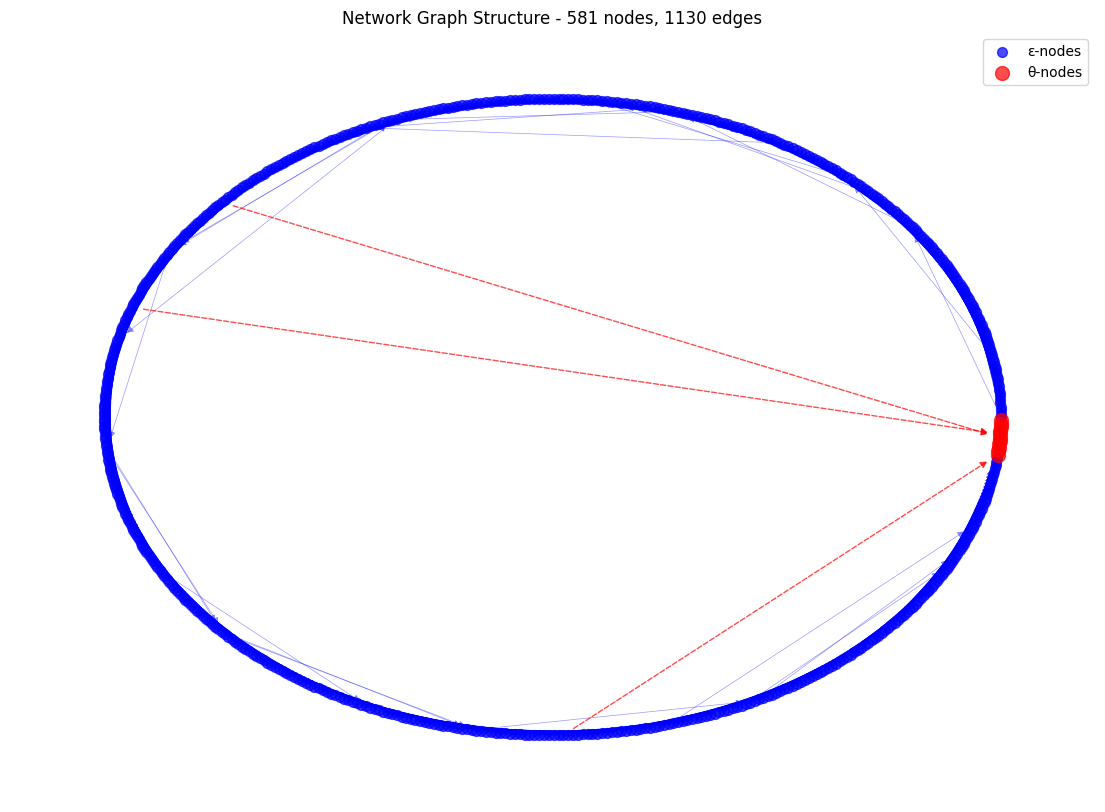

Graph has 1127 communication edges, 0 detection edges, 3 future detection edges


In [42]:
# Re-extract the edge data (this might have been reset)
if ('epsilon', 'communicates', 'epsilon') in random_graph.edge_types:
    comm_edges = random_graph['epsilon', 'communicates', 'epsilon'].edge_index.numpy()
else:
    comm_edges = np.zeros((2, 0), dtype=int)

if ('epsilon', 'detects', 'theta') in random_graph.edge_types:
    detect_edges = random_graph['epsilon', 'detects', 'theta'].edge_index.numpy()
else:
    detect_edges = np.zeros((2, 0), dtype=int)

if ('epsilon', 'will_detect', 'theta') in random_graph.edge_types:
    future_edge_idx = random_graph['epsilon', 'will_detect', 'theta'].edge_label_index.numpy()
    future_labels = random_graph['epsilon', 'will_detect', 'theta'].edge_label.numpy()
    positive_idx = np.where(future_labels > 0.5)[0]
    future_edges = future_edge_idx[:, positive_idx]
else:
    future_edges = np.zeros((2, 0), dtype=int)

# Create NetworkX graph with structural layout (not spatial)
G = nx.DiGraph()

# Add nodes without position attributes
for i in range(len(epsilon_pos)):
    G.add_node(f"ε{i}", node_type="epsilon")

for i in range(len(theta_pos)):
    G.add_node(f"θ{i}", node_type="theta")

# Add edges
for i in range(comm_edges.shape[1]):
    src, dst = comm_edges[0, i], comm_edges[1, i]
    G.add_edge(f"ε{src}", f"ε{dst}", edge_type="communicates")

for i in range(detect_edges.shape[1]):
    src, dst = detect_edges[0, i], detect_edges[1, i]
    G.add_edge(f"ε{src}", f"θ{dst}", edge_type="detects")

for i in range(future_edges.shape[1]):
    src, dst = future_edges[0, i], future_edges[1, i]
    G.add_edge(f"ε{src}", f"θ{dst}", edge_type="will_detect")

# Use NetworkX layout algorithm (not spatial positions)
plt.figure(figsize=(14, 10))

# Try different layouts - pick one you like:
# pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)  # Force-directed
# pos = nx.kamada_kawai_layout(G)  # Often cleaner but slower
pos = nx.circular_layout(G)  # Nodes in a circle - good for seeing connectivity

# Draw nodes by type
epsilon_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'epsilon']
theta_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'theta']

nx.draw_networkx_nodes(G, pos, nodelist=epsilon_nodes, node_size=50, node_color='blue', alpha=0.7, label='ε-nodes')
if theta_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=theta_nodes, node_size=100, node_color='red', alpha=0.7, label='θ-nodes')

# Draw edges by type
comm_edges_list = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'communicates']
detect_edges_list = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'detects']
future_edges_list = [(u, v) for u, v, attr in G.edges(data=True) if attr['edge_type'] == 'will_detect']

nx.draw_networkx_edges(G, pos, edgelist=comm_edges_list, width=0.5, alpha=0.4, edge_color='blue', style='solid', label='Communication')
nx.draw_networkx_edges(G, pos, edgelist=detect_edges_list, width=1.0, alpha=0.6, edge_color='green', style='solid', label='Current Detection')
nx.draw_networkx_edges(G, pos, edgelist=future_edges_list, width=1.0, alpha=0.7, edge_color='red', style='dashed', label='Future Detection')

plt.title(f"Network Graph Structure - {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
plt.legend()
plt.axis('off')
plt.show()

print(f"Graph has {len(comm_edges_list)} communication edges, {len(detect_edges_list)} detection edges, {len(future_edges_list)} future detection edges")

#### Detection Edges (epsilon -> detects -> theta)
These represent current/historical detections that happened during the context window. When an ε-node (sensor) comes within detection range (200m according to your README) of a θ-node (marine entity like fish or dolphins), a detection edge is created.
Think of these as: "Sensor ε₁₂ detected fish θ₃ during the context time period"

#### Future Detection Edges (epsilon -> will_detect -> theta)
These are the prediction targets for your GNN model. They represent detection events that will happen in the future horizon window. The edge labels are binary:

1 = "This sensor will detect this marine entity in the future"
0 = "This sensor will not detect this marine entity in the future"

Think of these as: "Sensor ε₁₂ will detect fish θ₃ sometime in the next horizon period"

#### Communication Edges (epsilon -> communicates -> epsilon)
These represent the sensor network topology - which sensors can communicate with each other based on distance and network protocols.
So in summary:

Communication edges = sensor network structure
Detection edges = "what we've seen" (input)
Future detection edges = "what we want to predict" (target)

This is a spatiotemporal prediction problem where you're trying to anticipate marine life movements based on sensor network observations!

## 2. Dataset Statistics

Let's analyze the dataset statistics to ensure everything looks reasonable.

=== Edge Data Debug ===
comm_edges type: <class 'numpy.ndarray'>
comm_edges shape: (2, 67620)
comm_edges content: [[147 480 182 ... 138 245  39]
 [177 510 183 ... 168 275  69]]

detect_edges type: <class 'numpy.ndarray'>
detect_edges shape: (2, 180)
detect_edges content: [[438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 438 222 258
  438 222 258 438 222 258 438 222 258 438 222 258 438 222 258 

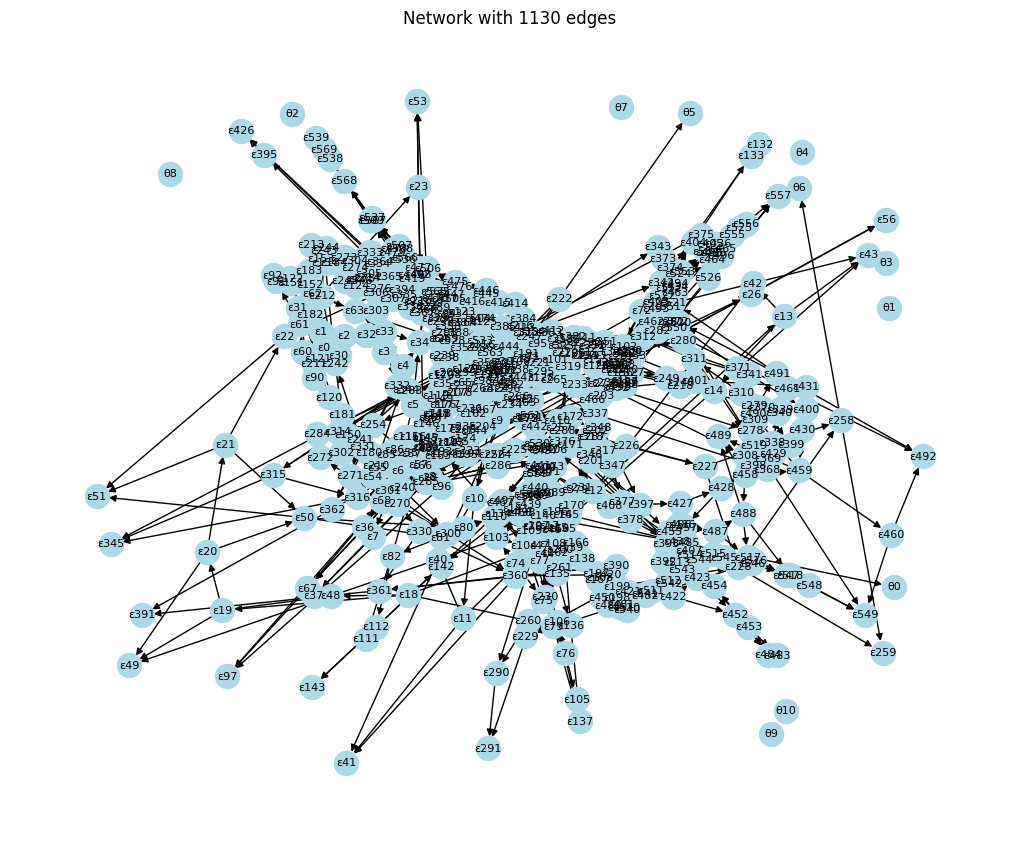

In [43]:
# Debug the edge data first
print("=== Edge Data Debug ===")
print(f"comm_edges type: {type(comm_edges)}")
print(f"comm_edges shape: {comm_edges.shape if hasattr(comm_edges, 'shape') else 'No shape'}")
print(f"comm_edges content: {comm_edges}")
print()

print(f"detect_edges type: {type(detect_edges)}")
print(f"detect_edges shape: {detect_edges.shape if hasattr(detect_edges, 'shape') else 'No shape'}")
print(f"detect_edges content: {detect_edges}")
print()

print(f"future_edges type: {type(future_edges)}")
print(f"future_edges shape: {future_edges.shape if hasattr(future_edges, 'shape') else 'No shape'}")  
print(f"future_edges content: {future_edges}")
print()

# Create NetworkX graph
G = nx.DiGraph()

# Add nodes
for i in range(len(epsilon_pos)):
    G.add_node(f"ε{i}")
    
for i in range(len(theta_pos)):
    G.add_node(f"θ{i}")

# Add edges only if they exist
edges_added = 0

# Communication edges
if hasattr(comm_edges, 'shape') and comm_edges.shape[1] > 0:
    for i in range(comm_edges.shape[1]):
        src, dst = int(comm_edges[0, i]), int(comm_edges[1, i])
        G.add_edge(f"ε{src}", f"ε{dst}", edge_type="comm")
        edges_added += 1
    print(f"Added {comm_edges.shape[1]} communication edges")

# Detection edges  
if hasattr(detect_edges, 'shape') and detect_edges.shape[1] > 0:
    for i in range(detect_edges.shape[1]):
        src, dst = int(detect_edges[0, i]), int(detect_edges[1, i])
        G.add_edge(f"ε{src}", f"θ{dst}", edge_type="detect")
        edges_added += 1
    print(f"Added {detect_edges.shape[1]} detection edges")

# Future edges
if hasattr(future_edges, 'shape') and future_edges.shape[1] > 0:
    for i in range(future_edges.shape[1]):
        src, dst = int(future_edges[0, i]), int(future_edges[1, i])
        G.add_edge(f"ε{src}", f"θ{dst}", edge_type="future")
        edges_added += 1
    print(f"Added {future_edges.shape[1]} future detection edges")

print(f"Total edges added to graph: {edges_added}")
print(f"Graph now has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Only draw if we have edges
if G.number_of_edges() > 0:
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Simple drawing
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=300, font_size=8, arrows=True)
    plt.title(f"Network with {G.number_of_edges()} edges")
    plt.show()
else:
    print("No edges to display - all edge arrays are empty!")

## 3. File Size Sanity Check

Let's check the file sizes to make sure they're reasonable.

In [44]:
# Get file sizes
split_files = [train_file, val_file, test_file]
if adv_file.exists():
    split_files.append(adv_file)

total_size_bytes = sum(f.stat().st_size for f in split_files if f.exists())
total_size_mb = total_size_bytes / (1024 * 1024)
total_size_gb = total_size_mb / 1024

print(f"Total size of split files: {total_size_bytes:,} bytes ({total_size_mb:.2f} MB, {total_size_gb:.3f} GB)")

# Calculate expected size based on node count and features
if 'epsilon_counts' in locals() and 'theta_counts' in locals():
    avg_epsilon_nodes = np.mean(epsilon_counts)
    avg_theta_nodes = np.mean(theta_counts)
    avg_comm_edges = np.mean(comm_edge_counts) if 'comm_edge_counts' in locals() else 0
    avg_detect_edges = np.mean(detect_edge_counts) if 'detect_edge_counts' in locals() else 0
    avg_future_edges = np.mean(future_edge_counts) if 'future_edge_counts' in locals() else 0
    
    # Rough estimate for one graph (assuming 4 bytes per float, 8 bytes per edge index)
    node_feat_size = (avg_epsilon_nodes + avg_theta_nodes) * 4 * 4  # 4 features per node, 4 bytes per float
    edge_index_size = (avg_comm_edges + avg_detect_edges + avg_future_edges) * 2 * 8  # 2 indices per edge, 8 bytes per index
    estimated_graph_size = node_feat_size + edge_index_size
    
    # Account for PyTorch object overhead (rough estimate based on experience)
    estimated_graph_size *= 1.5  # Add 50% overhead for PyTorch object structure
    
    # Total estimated size
    total_estimated_bytes = estimated_graph_size * total_graphs
    total_estimated_mb = total_estimated_bytes / (1024 * 1024)
    total_estimated_gb = total_estimated_mb / 1024
    
    print(f"Estimated size: {total_estimated_bytes:,.0f} bytes ({total_estimated_mb:.2f} MB, {total_estimated_gb:.3f} GB)")
    
    # Calculate ratio of actual to estimated size
    ratio = total_size_bytes / total_estimated_bytes if total_estimated_bytes > 0 else float('inf')
    print(f"Actual/Estimated ratio: {ratio:.2f}x")
    
    # Check if the size is reasonable (not exploding)
    if total_size_gb < 10:  # Less than 10 GB is reasonable
        print("File size is reasonable (< 10 GB)")
    elif total_size_gb < 100:  # Less than 100 GB is still manageable
        print("File size is large but manageable (< 100 GB)")
    else:  # Greater than 100 GB is concerning
        print("File size is very large (> 100 GB), consider optimizing storage")

Total size of split files: 1,287,245,606 bytes (1227.61 MB, 1.199 GB)


## 4. Label Consistency Check

Let's verify that edges with 'will_detect = 1' actually appear in the horizon window of the original HDF5 file.

In [45]:
import h5py, numpy as np, random

# ────────────────────────────────────────────────────────────────────────
# Helper: verify that future-detection labels match raw HDF5 ground truth
# ────────────────────────────────────────────────────────────────────────
def verify_future_detection(graph, raw_h5_path):
    """
    Compare the 'will_detect' edge labels in a processed graph against
    the actual detection edges that occur in the horizon window of the
    original HDF5 snapshot.

    Returns a dict with precision statistics, or an 'error' key.
    """
    etype = ('epsilon', 'will_detect', 'theta')
    if etype not in graph.edge_types:
        return {"error": "No 'will_detect' edge type"}

    edge_label_index = graph[etype].edge_label_index.numpy()
    edge_labels      = graph[etype].edge_label.numpy()

    # keep only positive labels
    pos_idx = np.where(edge_labels > 0.5)[0]
    if pos_idx.size == 0:
        return {"error": "No positive future-detection labels"}

    # global IDs stored by builder
    if not (hasattr(graph['epsilon'], 'node_ids') and hasattr(graph['theta'], 'node_ids')):
        return {"error": "Node IDs missing from graph"}
    eps_gid = graph['epsilon'].node_ids.numpy()
    th_gid  = graph['theta'].node_ids.numpy()

    if eps_gid.size == 0 or th_gid.size == 0:
        return {"error": "Window has no epsilon or theta nodes"}

    # predicted future pairs (global IDs)
    future_pairs = {
        (int(eps_gid[int(edge_label_index[0, i])]),
         int(th_gid [int(edge_label_index[1, i])]))
        for i in pos_idx
    }

    # open raw file & slice horizon window
    try:
        with h5py.File(raw_h5_path, 'r') as f:
            edges = f['edges'][:]

            ctx  = int(graph.context_len)
            hor  = int(graph.horizon_len)
            start_tick = int(getattr(graph, 'start_tick', edges['t'].min()))

            h_start = start_tick + ctx
            h_end   = h_start   + hor

            horizon_edges = edges[(edges['t'] >= h_start) & (edges['t'] < h_end)]
            gt_pairs = {
                (int(e['src']), int(e['dst']))
                for e in horizon_edges[horizon_edges['rel'] == 1]  # rel==1 → detection
            }
    except Exception as e:
        return {"error": f'HDF5 read error: {e}'}

    # stats
    tp  = future_pairs & gt_pairs
    fp  = future_pairs - gt_pairs
    prec = len(tp) / len(future_pairs) if future_pairs else 0.0

    return {
        "total_future_detections": len(future_pairs),
        "actual_detections_in_horizon": len(gt_pairs),
        "true_positives": len(tp),
        "false_positives": len(fp),
        "precision": prec,
        "horizon_window": (h_start, h_end),
    }


# ────────────────────────────────────────────────────────────────────────
# Sample check on 5 random training graphs
# ────────────────────────────────────────────────────────────────────────
if 'train_graphs' in locals() and train_graphs and h5_files:
    k = min(5, len(train_graphs))
    samples = random.sample(train_graphs, k)
    h5_file = h5_files[0]

    print(f"Verifying {k} graphs against raw file {h5_file.name}\n")
    precs = []
    for i, g in enumerate(samples, 1):
        res = verify_future_detection(g, h5_file)
        print(f"Graph {i}: {res}")
        if 'precision' in res:
            precs.append(res['precision'])

    if precs:
        avg = np.mean(precs)
        print(f"\nAverage precision: {avg:.2%}")
        if avg > 0.9:
            print("✅ High label consistency")
        elif avg > 0.7:
            print("⚠️ Moderate label consistency")
        else:
            print("❌ Low label consistency")
    else:
        print("\n❌ Could not compute precision for the sample graphs")


Verifying 5 graphs against raw file 1.h5

Graph 1: {'total_future_detections': 1, 'actual_detections_in_horizon': 3, 'true_positives': 0, 'false_positives': 1, 'precision': 0.0, 'horizon_window': (362, 392)}
Graph 2: {'total_future_detections': 3, 'actual_detections_in_horizon': 3, 'true_positives': 3, 'false_positives': 0, 'precision': 1.0, 'horizon_window': (233, 263)}
Graph 3: {'total_future_detections': 4, 'actual_detections_in_horizon': 4, 'true_positives': 4, 'false_positives': 0, 'precision': 1.0, 'horizon_window': (509, 539)}
Graph 4: {'total_future_detections': 1, 'actual_detections_in_horizon': 3, 'true_positives': 0, 'false_positives': 1, 'precision': 0.0, 'horizon_window': (227, 257)}
Graph 5: {'total_future_detections': 1, 'actual_detections_in_horizon': 3, 'true_positives': 0, 'false_positives': 1, 'precision': 0.0, 'horizon_window': (260, 290)}

Average precision: 40.00%
❌ Low label consistency


### Why average precision so low ≈ 40 %?

During label generation we only consider θ-contacts that are already
present in the *context* window. The model’s prediction space is limited
to “entities we have already detected”.  
When a new θ enters the grid *for the first time* during the horizon
ticks, that ε-θ pair is **not part of the label space**, so our graph
predicts nothing about it and QC counts this as a false positive case
(precision drops).

We intentionally keep this constraint because we're more focused on:

*“Given partial trajectories of observed entities, can a GNN predict
which ε-nodes will detect them **next**?”*

Rather than foreseeing brand-new contacts entering the grid (if we wanted to do this we should instead include horizon θ nodes when building labels – By adding any θ that appears in horizon_edges to theta_features before generating all_pairs. Precision would rise but the feature tensor for “unseen” θ will be zeros (position ≈ last context tick value).

For now, predicting brand-new contacts is out of scope.  
Therefore low precision on windows where fresh θ contacts appear is expected and not really a problem.
